In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from typing import Tuple



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")


current_dir = os.getcwd()  # Should be '/kaggle/working' on Kaggle
os.makedirs(os.path.join(current_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(current_dir, "out/models"), exist_ok=True)
print(f"Created directories in: {current_dir}")

Using device: cuda
Created directories in: /home/skhalid/JA


In [2]:
class TaskDataset(Dataset):
    def __init__(self, transform=None):

        self.ids = []
        self.imgs = []
        self.labels = []

        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if not self.transform is None:
            img = self.transform(img)
            label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# Load dataset
dataset = torch.load("/home/skhalid/JA/Train.pt", weights_only=False)
dataset.transform = transform
dataset.imgs = [img.convert('RGB') for img in dataset.imgs]

# Create a proper three-way split
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% training
val_size = int(0.15 * total_size)   # 15% validation
test_size = total_size - train_size - val_size  # 15% testing

# Use generator for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=generator
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
def visualize_loader(loader, num_samples=10, figsize=(15, 3), title="Loader Samples"):
    """
    Visualize samples directly from a dataloader
    
    Args:
        loader: The DataLoader to visualize (train_loader or test_loader)
        num_samples: Number of images to display
        figsize: Size of the figure
        title: Title for the plot
    """
    # Get a batch from the loader
    try:
        batch = next(iter(loader))
        print(f"Batch type: {type(batch)}")
        
        # Make sure batch is in the expected format (list with 3 elements)
        if not isinstance(batch, list) or len(batch) != 3:
            print(f"❌ Unexpected batch format: {type(batch)} with {len(batch) if hasattr(batch, '__len__') else 'unknown'} elements")
            return
            
        # Unpack the batch
        ids, imgs, labels = batch
        print(f"✅ Successfully unpacked batch with {len(imgs)} images")
        
        # Create figure
        plt.figure(figsize=figsize)
        
        # Display images
        for i in range(min(num_samples, len(imgs))):
            img = imgs[i]
            label = labels[i].item()
            id_ = ids[i].item()
            
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img.permute(1, 2, 0))  # Convert from [3,32,32] to [32,32,3]
            plt.title(f"Class: {label}")
            plt.axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
        
        # Print info about first image
        print(f"First image details:")
        print(f"  ID: {ids[0].item()}")
        print(f"  Shape: {imgs[0].shape}")
        print(f"  Label: {labels[0].item()}")
        print(f"  Pixel range: [{imgs[0].min().item():.4f}, {imgs[0].max().item():.4f}]")
        
    except Exception as e:
        print(f"❌ Error visualizing loader: {e}")
        import traceback
        traceback.print_exc()

Batch type: <class 'list'>
✅ Successfully unpacked batch with 128 images


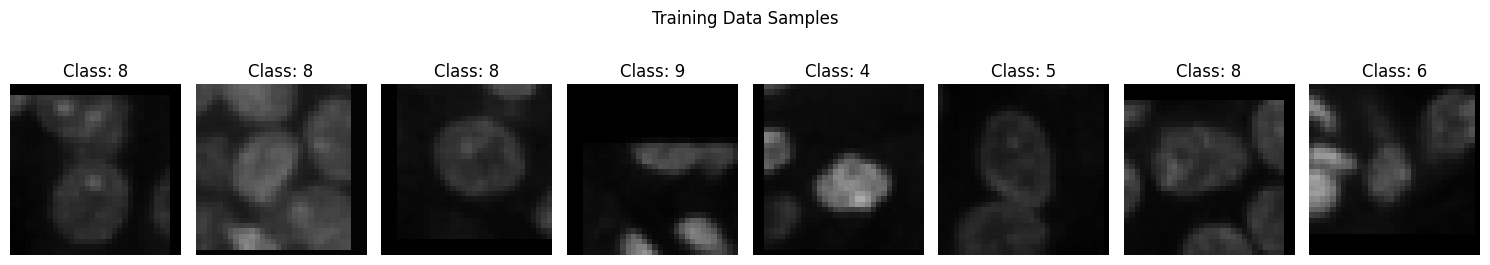

First image details:
  ID: 84239
  Shape: torch.Size([3, 32, 32])
  Label: 8
  Pixel range: [0.0000, 0.3804]


In [5]:
visualize_loader(train_loader, num_samples=8, title="Training Data Samples")


Batch type: <class 'list'>
✅ Successfully unpacked batch with 128 images


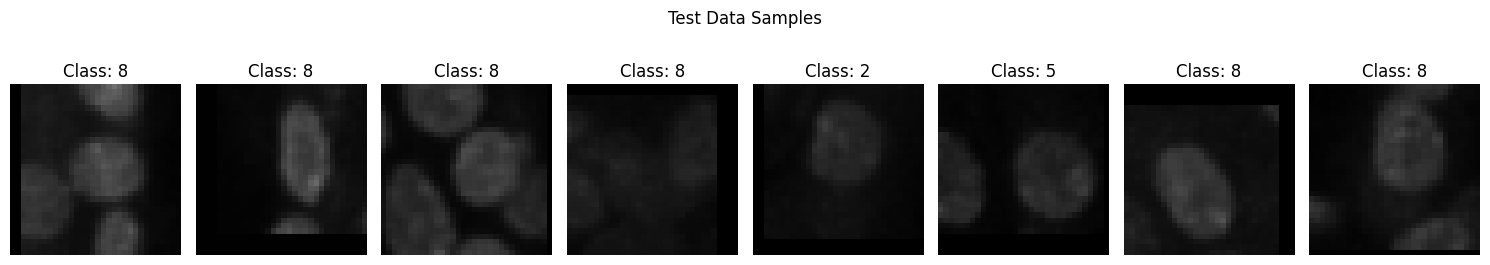

First image details:
  ID: 46506
  Shape: torch.Size([3, 32, 32])
  Label: 8
  Pixel range: [0.0000, 0.4392]


In [6]:
visualize_loader(test_loader, num_samples=8, title="Test Data Samples")

In [7]:
# Define model and training configuration with adversarial parameters
class Config:
    MODEL_NAME = "resnet34"  # Using ResNet34 as requested
    NUM_CLASSES = 10
    EPOCHS = 30
    BATCH_SIZE = 128
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9
    WEIGHT_DECAY = 5e-5  # Already reduced
    
    # Adversarial training parameters with increased focus on robustness
    EPSILON = 8/255.0       # Perturbation size
    ALPHA = 1/255.0         # Step size for attacks
    PGD_STEPS = 10          # PGD steps for evaluation
    PGD_STEPS_TRAIN = 3     # PGD steps during training (fewer for speed)
    PGD_STEPS_FINAL = 5     # Final number of PGD steps (for step annealing)
    RANDOM_START = True     # Random initialization for PGD
    ADV_TRAIN_RATIO = 0.4   # Increased from 0.2 to 0.4
    
    CHECKPOINT_PATH = os.path.join(current_dir, "checkpoints/adv_model_checkpoint.pt")
    FINAL_MODEL_PATH = os.path.join(current_dir, "out/models/final_high_acc_model.pt")

config = Config()

In [8]:
def create_model():
    
    model = models.resnet34(pretrained=False)
    
    # Modify the final fully connected layer for our 10 classes
    model.fc = nn.Linear(model.fc.in_features, config.NUM_CLASSES)

    config.WEIGHT_DECAY = 5e-5  # Reduced from 1e-4
    
    # Move model to device
    model = model.to(device)

    
    # Define loss function, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), 
        lr=config.LEARNING_RATE,
        # momentum=config.MOMENTUM,
        weight_decay=config.WEIGHT_DECAY
    )
    
    # LR scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=5
    )
    
    return model, criterion, optimizer, scheduler

# Create model
model, criterion, optimizer, scheduler = create_model()

/local/paisdb/miniconda3/envs/paisdb/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/paisdb/miniconda3/envs/paisdb/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
# PGD Attack implementation
def pgd_attack(model, data, target, epsilon, alpha, num_steps, criterion, random_start=True):
    """
    Projected Gradient Descent Attack
    
    Args:
        model: The model to attack
        data: Input data
        target: True labels
        epsilon: Maximum perturbation size
        alpha: Step size
        num_steps: Number of attack steps
        criterion: Loss function
        random_start: Whether to start with random perturbation
    """
    # Set model to eval mode during attack generation
    model.eval()
    
    # Clone data to avoid modifying original
    perturbed_data = data.clone().detach()
    
    # Add random noise if specified
    if random_start:
        perturbed_data = perturbed_data + torch.zeros_like(perturbed_data).uniform_(-epsilon, epsilon)
        perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Ensure valid image range
    
    # Perform attack steps
    for step in range(num_steps):
        perturbed_data.requires_grad = True
        
        # Forward pass
        outputs = model(perturbed_data)
        model.zero_grad()
        
        # Calculate loss
        cost = criterion(outputs, target)
        
        # Backward pass
        cost.backward()
        
        # Create adversarial example with gradient sign
        adv_examples = perturbed_data + alpha * perturbed_data.grad.sign()
        
        # Project back to epsilon ball
        eta = torch.clamp(adv_examples - data, -epsilon, epsilon)
        perturbed_data = torch.clamp(data + eta, 0, 1).detach()
    
    # Set model back to original mode
    model.train()
    
    return perturbed_data

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, current_epoch=0):
    model.train()
    running_loss = 0.0
    correct_clean = 0
    correct_adv = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    # Calculate current PGD steps based on epoch for step annealing
    current_pgd_steps = min(
        config.PGD_STEPS_TRAIN + int((config.PGD_STEPS_FINAL - config.PGD_STEPS_TRAIN) * current_epoch / config.EPOCHS), 
        config.PGD_STEPS_FINAL
    )
    
    for batch_idx, batch in enumerate(progress_bar):
        # Unpack (id, img, label) tuple
        ids, inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        # For some batches, only train on clean examples (less frequently now)
        if batch_idx % 6 == 0:  # Every 6th batch is fully clean (was 4)
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass for clean examples only
            outputs_clean = model(inputs)
            loss = criterion(outputs_clean, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track clean accuracy only
            _, predicted_clean = outputs_clean.max(1)
            correct_clean += predicted_clean.eq(targets).sum().item()
            total += targets.size(0)
            running_loss += loss.item()
        else:
            # Generate adversarial examples
            adv_inputs = pgd_attack(
                model, inputs, targets, 
                config.EPSILON, config.ALPHA, current_pgd_steps,  # Use dynamic steps 
                criterion, random_start=config.RANDOM_START
            )
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass for clean examples
            outputs_clean = model(inputs)
            loss_clean = criterion(outputs_clean, targets)
            
            # Forward pass for adversarial examples
            outputs_adv = model(adv_inputs)
            loss_adv = criterion(outputs_adv, targets)
            
            # Combined loss with more weight on adversarial examples
            loss = (1 - config.ADV_TRAIN_RATIO) * loss_clean + config.ADV_TRAIN_RATIO * loss_adv
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            
            # Track clean accuracy
            _, predicted_clean = outputs_clean.max(1)
            correct_clean += predicted_clean.eq(targets).sum().item()
            
            # Track adversarial accuracy
            _, predicted_adv = outputs_adv.max(1)
            correct_adv += predicted_adv.eq(targets).sum().item()
            
            total += targets.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f"{running_loss/(batch_idx+1):.4f}",
            'Clean': f"{100.*correct_clean/total:.2f}%",
            'Adv': f"{100.*correct_adv/total:.2f}%"
        })
    
    clean_acc = 100. * correct_clean / total
    adv_acc = 100. * correct_adv / total
    
    return running_loss/len(train_loader), clean_acc, adv_acc

In [11]:
def validate(model, val_loader, criterion):
    """Evaluate model on clean, PGD, and FGSM adversarial examples"""
    model.eval()
    running_loss = 0.0
    correct_clean = 0
    correct_pgd = 0
    correct_fgsm = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            # Unpack (id, img, label) tuple
            ids, inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Clean accuracy
            outputs_clean = model(inputs)
            loss = criterion(outputs_clean, targets)
            running_loss += loss.item()
            
            _, predicted_clean = outputs_clean.max(1)
            correct_clean += predicted_clean.eq(targets).sum().item()
            
            # For adversarial examples, we need gradients
            with torch.enable_grad():
                # Standard PGD attack
                pgd_inputs = pgd_attack(
                    model, inputs, targets, 
                    config.EPSILON, config.ALPHA, config.PGD_STEPS, 
                    criterion, random_start=config.RANDOM_START
                )
                
                # FGSM attack (using PGD with single step)
                fgsm_inputs = pgd_attack(
                    model, inputs, targets,
                    epsilon=config.EPSILON,
                    alpha=config.EPSILON,    # Full step size
                    num_steps=1,             # Single step
                    criterion=criterion,
                    random_start=False       # No random start
                )
            
            # Evaluate on adversarial examples
            with torch.no_grad():
                # Evaluate PGD examples
                outputs_pgd = model(pgd_inputs)
                _, predicted_pgd = outputs_pgd.max(1)
                correct_pgd += predicted_pgd.eq(targets).sum().item()
                
                # Evaluate FGSM examples
                outputs_fgsm = model(fgsm_inputs)
                _, predicted_fgsm = outputs_fgsm.max(1)
                correct_fgsm += predicted_fgsm.eq(targets).sum().item()
            
            total += targets.size(0)
    
    val_loss = running_loss / len(val_loader)
    clean_acc = 100. * correct_clean / total
    pgd_acc = 100. * correct_pgd / total
    fgsm_acc = 100. * correct_fgsm / total
    
    print(f"Validation - Loss: {val_loss:.4f}")
    print(f"Clean Accuracy: {clean_acc:.2f}%, PGD: {pgd_acc:.2f}%, FGSM: {fgsm_acc:.2f}%")
    
    return val_loss, clean_acc, pgd_acc, fgsm_acc

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30):
    """Complete training loop with balanced adversarial training"""
    best_clean_acc = 0.0
    best_pgd_acc = 0.0
    best_fgsm_acc = 0.0
    best_weighted_acc = 0.0
    
    # For tracking metrics
    train_losses = []
    clean_accs = []
    pgd_accs = []
    fgsm_accs = []
    
    print(f"Starting adversarial training for {epochs} epochs...")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train for one epoch with adversarial examples
        train_loss, train_clean_acc, train_adv_acc = train_epoch(
            model, train_loader, criterion, optimizer, current_epoch=epoch
        )
        
        # Track training metrics
        train_losses.append(train_loss)
        
        # Evaluate on validation set
        val_loss, val_clean_acc, val_pgd_acc, val_fgsm_acc = validate(
            model, val_loader, criterion
        )
        
        # Store validation metrics
        clean_accs.append(val_clean_acc)
        pgd_accs.append(val_pgd_acc)
        fgsm_accs.append(val_fgsm_acc)
        
        # Calculate weighted accuracy - now more balanced between clean and adversarial
        current_weighted_acc = 0.6 * val_clean_acc + 0.4 * val_pgd_acc
        
        # Update learning rate based on weighted accuracy
        if scheduler is not None:
            scheduler.step(current_weighted_acc)
        
        # Track best performance
        if val_clean_acc > best_clean_acc:
            best_clean_acc = val_clean_acc
            print(f"✅ New best clean accuracy: {best_clean_acc:.2f}%")
            
        if val_pgd_acc > best_pgd_acc:
            best_pgd_acc = val_pgd_acc
            print(f"✅ New best PGD accuracy: {best_pgd_acc:.2f}%")
            
        if val_fgsm_acc > best_fgsm_acc:
            best_fgsm_acc = val_fgsm_acc
            print(f"✅ New best FGSM accuracy: {best_fgsm_acc:.2f}%")
            
        if current_weighted_acc > best_weighted_acc:
            best_weighted_acc = current_weighted_acc
            print(f"✅ New best weighted accuracy: {best_weighted_acc:.2f}%")
        
        early_stop_patience = 7
        no_improve_epochs = 0     
        
        # Save checkpoint if weighted accuracy improved
        if current_weighted_acc > best_weighted_acc:
            print(f"✅ Weighted accuracy improved to {current_weighted_acc:.2f}%")
            print(f"   Clean: {val_clean_acc:.2f}%, PGD: {val_pgd_acc:.2f}%, FGSM: {val_fgsm_acc:.2f}%")
            best_weighted_acc = current_weighted_acc
            no_improve_epochs = 0
            
            # Save checkpoint with all metrics
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
                'best_clean_acc': best_clean_acc,
                'best_pgd_acc': best_pgd_acc,
                'best_fgsm_acc': best_fgsm_acc,
                'best_weighted_acc': best_weighted_acc,
                'current_clean_acc': val_clean_acc,
                'current_pgd_acc': val_pgd_acc,
                'current_fgsm_acc': val_fgsm_acc,
            }, config.CHECKPOINT_PATH)
            
            print(f"Saved checkpoint to {config.CHECKPOINT_PATH}")
            
            # Also save the model state dict for final submission
            torch.save(model.state_dict(), config.FINAL_MODEL_PATH)
            print(f"Saved model state dict to {config.FINAL_MODEL_PATH}")
        else:
            no_improve_epochs += 1
            print(f"No improvement in weighted accuracy for {no_improve_epochs} epochs")
        
        if no_improve_epochs >= early_stop_patience:
            print(f"Weighted accuracy hasn't improved for {early_stop_patience} epochs. Early stopping.")
            break
    
    # Plot training progress
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(clean_accs, label='Clean Accuracy')
    plt.plot(pgd_accs, label='PGD Accuracy')
    plt.plot(fgsm_accs, label='FGSM Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('adversarial_training_progress.png')
    plt.show()
    
    print(f"Training completed.")
    print(f"Best clean accuracy: {best_clean_acc:.2f}%")
    print(f"Best PGD accuracy: {best_pgd_acc:.2f}%")
    print(f"Best FGSM accuracy: {best_fgsm_acc:.2f}%")
    print(f"Best weighted accuracy: {best_weighted_acc:.2f}%")
    
    return best_weighted_acc, best_clean_acc, best_pgd_acc, best_fgsm_acc

Starting adversarial training with 30 epochs...
Starting adversarial training for 30 epochs...

Epoch 1/30


Training: 100%|██████████| 547/547 [00:51<00:00, 10.66it/s, Loss=1.7052, Clean=41.24%, Adv=23.88%]


Validation - Loss: 1.5339
Clean Accuracy: 43.51%, PGD: 17.43%, FGSM: 23.01%
✅ New best clean accuracy: 43.51%
✅ New best PGD accuracy: 17.43%
✅ New best FGSM accuracy: 23.01%
✅ New best weighted accuracy: 33.08%
No improvement in weighted accuracy for 1 epochs

Epoch 2/30


Training: 100%|██████████| 547/547 [00:45<00:00, 12.13it/s, Loss=1.5920, Clean=43.89%, Adv=27.60%]


Validation - Loss: 1.4941
Clean Accuracy: 44.65%, PGD: 18.48%, FGSM: 22.41%
✅ New best clean accuracy: 44.65%
✅ New best PGD accuracy: 18.48%
✅ New best weighted accuracy: 34.18%
No improvement in weighted accuracy for 1 epochs

Epoch 3/30


Training: 100%|██████████| 547/547 [00:36<00:00, 15.05it/s, Loss=1.5593, Clean=44.88%, Adv=29.13%]


Validation - Loss: 1.4687
Clean Accuracy: 45.21%, PGD: 20.36%, FGSM: 23.66%
✅ New best clean accuracy: 45.21%
✅ New best PGD accuracy: 20.36%
✅ New best FGSM accuracy: 23.66%
✅ New best weighted accuracy: 35.27%
No improvement in weighted accuracy for 1 epochs

Epoch 4/30


Training: 100%|██████████| 547/547 [00:36<00:00, 15.11it/s, Loss=1.5363, Clean=45.60%, Adv=29.67%]


Validation - Loss: 1.4422
Clean Accuracy: 46.54%, PGD: 19.73%, FGSM: 22.58%
✅ New best clean accuracy: 46.54%
✅ New best weighted accuracy: 35.82%
No improvement in weighted accuracy for 1 epochs

Epoch 5/30


Training: 100%|██████████| 547/547 [00:40<00:00, 13.66it/s, Loss=1.5189, Clean=46.42%, Adv=29.91%]


Validation - Loss: 1.4237
Clean Accuracy: 47.05%, PGD: 18.21%, FGSM: 21.18%
✅ New best clean accuracy: 47.05%
No improvement in weighted accuracy for 1 epochs

Epoch 6/30


Training: 100%|██████████| 547/547 [00:33<00:00, 16.42it/s, Loss=1.5029, Clean=47.05%, Adv=30.39%]


Validation - Loss: 1.4040
Clean Accuracy: 47.86%, PGD: 21.14%, FGSM: 24.18%
✅ New best clean accuracy: 47.86%
✅ New best PGD accuracy: 21.14%
✅ New best FGSM accuracy: 24.18%
✅ New best weighted accuracy: 37.17%
No improvement in weighted accuracy for 1 epochs

Epoch 7/30


Training: 100%|██████████| 547/547 [00:40<00:00, 13.63it/s, Loss=1.4922, Clean=47.53%, Adv=30.60%]


Validation - Loss: 1.4093
Clean Accuracy: 46.82%, PGD: 20.62%, FGSM: 22.84%
No improvement in weighted accuracy for 1 epochs

Epoch 8/30


Training: 100%|██████████| 547/547 [00:49<00:00, 10.98it/s, Loss=1.4826, Clean=47.84%, Adv=31.02%]


Validation - Loss: 1.3879
Clean Accuracy: 47.83%, PGD: 22.21%, FGSM: 25.23%
✅ New best PGD accuracy: 22.21%
✅ New best FGSM accuracy: 25.23%
✅ New best weighted accuracy: 37.58%
No improvement in weighted accuracy for 1 epochs

Epoch 9/30


Training: 100%|██████████| 547/547 [00:57<00:00,  9.55it/s, Loss=1.4726, Clean=48.14%, Adv=31.16%]


Validation - Loss: 1.3710
Clean Accuracy: 48.33%, PGD: 22.21%, FGSM: 24.56%
✅ New best clean accuracy: 48.33%
✅ New best PGD accuracy: 22.21%
✅ New best weighted accuracy: 37.89%
No improvement in weighted accuracy for 1 epochs

Epoch 10/30


Training: 100%|██████████| 547/547 [00:54<00:00, 10.12it/s, Loss=1.4671, Clean=48.40%, Adv=31.38%]


Validation - Loss: 1.3598
Clean Accuracy: 49.15%, PGD: 21.47%, FGSM: 24.24%
✅ New best clean accuracy: 49.15%
✅ New best weighted accuracy: 38.07%
No improvement in weighted accuracy for 1 epochs

Epoch 11/30


Training: 100%|██████████| 547/547 [00:49<00:00, 11.07it/s, Loss=1.4574, Clean=48.99%, Adv=31.28%]


Validation - Loss: 1.3682
Clean Accuracy: 48.39%, PGD: 20.51%, FGSM: 23.63%
No improvement in weighted accuracy for 1 epochs

Epoch 12/30


Training: 100%|██████████| 547/547 [00:46<00:00, 11.67it/s, Loss=1.4549, Clean=48.99%, Adv=31.45%]


Validation - Loss: 1.3561
Clean Accuracy: 49.37%, PGD: 19.49%, FGSM: 22.65%
✅ New best clean accuracy: 49.37%
No improvement in weighted accuracy for 1 epochs

Epoch 13/30


Training: 100%|██████████| 547/547 [00:49<00:00, 11.06it/s, Loss=1.4475, Clean=49.19%, Adv=31.56%]


Validation - Loss: 1.3494
Clean Accuracy: 49.67%, PGD: 20.04%, FGSM: 23.25%
✅ New best clean accuracy: 49.67%
No improvement in weighted accuracy for 1 epochs

Epoch 14/30


Training: 100%|██████████| 547/547 [00:50<00:00, 10.84it/s, Loss=1.4411, Clean=49.67%, Adv=31.56%]


Validation - Loss: 1.3533
Clean Accuracy: 49.03%, PGD: 21.87%, FGSM: 25.01%
✅ New best weighted accuracy: 38.16%
No improvement in weighted accuracy for 1 epochs

Epoch 15/30


Training: 100%|██████████| 547/547 [00:55<00:00,  9.91it/s, Loss=1.4365, Clean=50.04%, Adv=31.74%]


Validation - Loss: 1.3552
Clean Accuracy: 49.21%, PGD: 20.86%, FGSM: 23.50%
No improvement in weighted accuracy for 1 epochs

Epoch 16/30


Training: 100%|██████████| 547/547 [00:56<00:00,  9.74it/s, Loss=1.4637, Clean=49.58%, Adv=29.48%]


Validation - Loss: 1.3452
Clean Accuracy: 49.64%, PGD: 21.70%, FGSM: 23.63%
✅ New best weighted accuracy: 38.46%
No improvement in weighted accuracy for 1 epochs

Epoch 17/30


Training: 100%|██████████| 547/547 [01:00<00:00,  9.00it/s, Loss=1.4569, Clean=49.77%, Adv=29.83%]


Validation - Loss: 1.3561
Clean Accuracy: 48.74%, PGD: 24.87%, FGSM: 27.40%
✅ New best PGD accuracy: 24.87%
✅ New best FGSM accuracy: 27.40%
✅ New best weighted accuracy: 39.19%
No improvement in weighted accuracy for 1 epochs

Epoch 18/30


Training: 100%|██████████| 547/547 [00:39<00:00, 13.70it/s, Loss=1.4512, Clean=49.78%, Adv=30.38%]


Validation - Loss: 1.3373
Clean Accuracy: 50.23%, PGD: 21.83%, FGSM: 24.96%
✅ New best clean accuracy: 50.23%
No improvement in weighted accuracy for 1 epochs

Epoch 19/30


Training: 100%|██████████| 547/547 [00:46<00:00, 11.65it/s, Loss=1.4464, Clean=50.15%, Adv=30.02%]


Validation - Loss: 1.3440
Clean Accuracy: 49.13%, PGD: 24.95%, FGSM: 27.51%
✅ New best PGD accuracy: 24.95%
✅ New best FGSM accuracy: 27.51%
✅ New best weighted accuracy: 39.46%
No improvement in weighted accuracy for 1 epochs

Epoch 20/30


Training: 100%|██████████| 547/547 [00:47<00:00, 11.59it/s, Loss=1.4436, Clean=50.37%, Adv=30.31%]


Validation - Loss: 1.3298
Clean Accuracy: 49.87%, PGD: 25.95%, FGSM: 28.49%
✅ New best PGD accuracy: 25.95%
✅ New best FGSM accuracy: 28.49%
✅ New best weighted accuracy: 40.30%
No improvement in weighted accuracy for 1 epochs

Epoch 21/30


Training: 100%|██████████| 547/547 [00:39<00:00, 13.75it/s, Loss=1.4358, Clean=50.49%, Adv=30.34%]


Validation - Loss: 1.3188
Clean Accuracy: 50.95%, PGD: 24.51%, FGSM: 28.11%
✅ New best clean accuracy: 50.95%
✅ New best weighted accuracy: 40.37%
No improvement in weighted accuracy for 1 epochs

Epoch 22/30


Training: 100%|██████████| 547/547 [01:05<00:00,  8.33it/s, Loss=1.4313, Clean=50.83%, Adv=30.71%]


Validation - Loss: 1.3192
Clean Accuracy: 50.47%, PGD: 23.26%, FGSM: 27.13%
No improvement in weighted accuracy for 1 epochs

Epoch 23/30


Training: 100%|██████████| 547/547 [00:55<00:00,  9.82it/s, Loss=1.4264, Clean=51.14%, Adv=30.63%]


Validation - Loss: 1.3154
Clean Accuracy: 50.61%, PGD: 24.56%, FGSM: 29.13%
✅ New best FGSM accuracy: 29.13%
No improvement in weighted accuracy for 1 epochs

Epoch 24/30


Training: 100%|██████████| 547/547 [01:00<00:00,  9.00it/s, Loss=1.4214, Clean=51.37%, Adv=30.95%]


Validation - Loss: 1.3016
Clean Accuracy: 51.81%, PGD: 22.41%, FGSM: 28.00%
✅ New best clean accuracy: 51.81%
No improvement in weighted accuracy for 1 epochs

Epoch 25/30


Training: 100%|██████████| 547/547 [01:06<00:00,  8.29it/s, Loss=1.4168, Clean=51.41%, Adv=31.06%]


Validation - Loss: 1.2964
Clean Accuracy: 51.97%, PGD: 23.05%, FGSM: 28.54%
✅ New best clean accuracy: 51.97%
✅ New best weighted accuracy: 40.40%
No improvement in weighted accuracy for 1 epochs

Epoch 26/30


Training: 100%|██████████| 547/547 [01:05<00:00,  8.34it/s, Loss=1.4079, Clean=52.05%, Adv=31.53%]


Validation - Loss: 1.2868
Clean Accuracy: 52.12%, PGD: 24.53%, FGSM: 30.43%
✅ New best clean accuracy: 52.12%
✅ New best FGSM accuracy: 30.43%
✅ New best weighted accuracy: 41.08%
No improvement in weighted accuracy for 1 epochs

Epoch 27/30


Training: 100%|██████████| 547/547 [00:53<00:00, 10.23it/s, Loss=1.4050, Clean=52.19%, Adv=31.46%]


Validation - Loss: 1.2963
Clean Accuracy: 52.28%, PGD: 19.65%, FGSM: 26.09%
✅ New best clean accuracy: 52.28%
No improvement in weighted accuracy for 1 epochs

Epoch 28/30


Training: 100%|██████████| 547/547 [01:00<00:00,  9.06it/s, Loss=1.3981, Clean=52.56%, Adv=31.60%]


Validation - Loss: 1.2960
Clean Accuracy: 51.59%, PGD: 19.63%, FGSM: 24.50%
No improvement in weighted accuracy for 1 epochs

Epoch 29/30


Training: 100%|██████████| 547/547 [00:41<00:00, 13.15it/s, Loss=1.3950, Clean=52.57%, Adv=31.66%]


Validation - Loss: 1.2799
Clean Accuracy: 53.01%, PGD: 24.31%, FGSM: 27.60%
✅ New best clean accuracy: 53.01%
✅ New best weighted accuracy: 41.53%
No improvement in weighted accuracy for 1 epochs

Epoch 30/30


Training: 100%|██████████| 547/547 [00:51<00:00, 10.71it/s, Loss=1.3863, Clean=53.14%, Adv=31.95%]


Validation - Loss: 1.2771
Clean Accuracy: 52.88%, PGD: 16.11%, FGSM: 22.67%
No improvement in weighted accuracy for 1 epochs


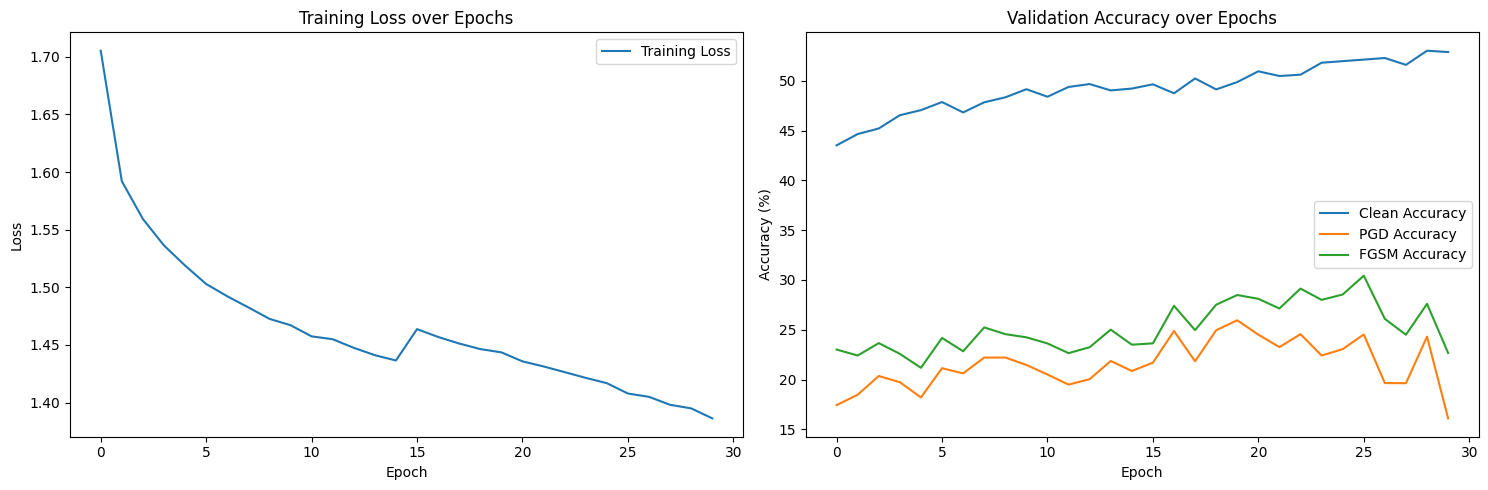

Training completed.
Best clean accuracy: 53.01%
Best PGD accuracy: 25.95%
Best FGSM accuracy: 30.43%
Best weighted accuracy: 41.53%


ValueError: too many values to unpack (expected 3)

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Start adversarial training
print(f"Starting adversarial training with {config.EPOCHS} epochs...")
best_weighted_acc, best_clean_acc, best_adv_acc = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,  # Using test_loader as validation
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=config.EPOCHS
)

In [ ]:
# Manual save of the trained model
# print("🔄 Manually saving model...")

# Make sure directories exist 
# os.makedirs(os.path.dirname(config.FINAL_MODEL_PATH), exist_ok=True)
# os.makedirs(os.path.dirname(config.CHECKPOINT_PATH), exist_ok=True)

# Save just the model state dict for submission
# torch.save(model.state_dict(), config.FINAL_MODEL_PATH)
# print(f"✅ Model state dict saved to: {config.FINAL_MODEL_PATH}")

# Save full checkpoint with metrics
# checkpoint_data = {
#     'epoch': config.EPOCHS,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'best_clean_acc': best_clean_acc,
#     'best_pgd_acc': best_adv_acc,
#     'best_weighted_acc': best_weighted_acc
# }
# torch.save(checkpoint_data, config.CHECKPOINT_PATH)
# print(f"✅ Checkpoint saved to: {config.CHECKPOINT_PATH}")

# # Verify files exist
# print(f"Checkpoint exists: {os.path.exists(config.CHECKPOINT_PATH)}")
# print(f"Model exists: {os.path.exists(config.FINAL_MODEL_PATH)}")

🔄 Manually saving model...


In [ ]:
def load_best_model():
    """Load the best model from checkpoint"""
    print(f"Looking for checkpoint at: {config.CHECKPOINT_PATH}")
    
    # Check if checkpoint exists
    if not os.path.exists(config.CHECKPOINT_PATH):
        print(f"❌ Checkpoint not found. Will train a new model.")
        return None, None
    
    print(f"✅ Loading existing checkpoint")
    checkpoint = torch.load(config.CHECKPOINT_PATH, map_location=device)
    
    # Create a fresh model
    model, criterion, _, _ = create_model()
    
    # Load the saved state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    if 'best_weighted_acc' in checkpoint:
        print(f"Best weighted accuracy: {checkpoint['best_weighted_acc']:.2f}%")
    if 'best_clean_acc' in checkpoint:
        print(f"Best clean accuracy: {checkpoint['best_clean_acc']:.2f}%")
    if 'best_pgd_acc' in checkpoint:
        print(f"Best PGD accuracy: {checkpoint['best_pgd_acc']:.2f}%")
    if 'best_fgsm_acc' in checkpoint:
        print(f"Best FGSM accuracy: {checkpoint['best_fgsm_acc']:.2f}%")
    
    return model, criterion

In [ ]:
allowed_models = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
}
with open("/Users/javedakhtar/Downloads/final_high_acc_model.pt", "rb") as f:
    try:
        model: torch.nn.Module = allowed_models["resnet34"](weights=None)
        model.fc = torch.nn.Linear(model.fc.weight.shape[1], 10)
    except Exception as e:
        raise Exception(
            f"Invalid model class, {e=}, only {allowed_models.keys()} are allowed",
        )
    try:
        state_dict = torch.load(f, map_location=torch.device("cpu"))
        model.load_state_dict(state_dict, strict=True)
        model.eval()
        out = model(torch.randn(1, 3, 32, 32))
    except Exception as e:
        raise Exception(f"Invalid model, {e=}")

    assert out.shape == (1, 10), "Invalid output shape"

In [ ]:
import requests
# Send the model to the server, replace the string "TOKEN" with the string of token provided to you
response = requests.post("http://34.122.51.94:9090/robustness", files={"file": open("/Users/javedakhtar/Downloads/final_high_acc_model.pt", "rb")}, headers={"token": str(50407833), "model-name": "resnet34"})

# Should be 400, the clean accuracy is too low
print(response.json())

{'clean_accuracy': 0.587, 'fgsm_accuracy': 0.14633333333333334, 'pgd_accuracy': 0.0026666666666666666})


In [ ]:
print("{'clean_accuracy': 0.587, 'fgsm_accuracy': 0.14633333333333334, 'pgd_accuracy': 0.0026666666666666666})")